# Полносвязные сетки

In [1]:
import copy
 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler

from sklearn.datasets import make_swiss_roll
from sklearn.utils import shuffle

%matplotlib inline

SEED = 777

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [2]:
# Read data
data = fetch_california_housing()
X, y = data.data, data.target
display(fetch_california_housing(as_frame=True).frame.head())
# train-test split for model evaluation
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)
 
# Standardizing data
scaler = StandardScaler()
scaler.fit(X_train_raw)
X_train = scaler.transform(X_train_raw)
X_test = scaler.transform(X_test_raw)
 
# Convert to 2D PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [3]:
# Define the model
model = nn.Sequential(
    nn.Linear(8, 24),
    nn.ReLU(),
    nn.Linear(24, 12),
    nn.ReLU(),
    nn.Linear(12, 6),
    nn.ReLU(),
    nn.Linear(6, 1)
)

In [4]:
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)
 
n_epochs = 100   # number of epochs to run
batch_size = 10  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []

In [5]:
for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=2, disable=False) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())

Epoch 19:   0%|                                                                                                             | 0/1445 [00:00<?, ?batch/s, mse=0.16]IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 23:   0%|                                                                                                             | 0/1445 [00:00<?, ?batch/s, mse=0.27]IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 27:   0%|                   

MSE: 0.30
RMSE: 0.55


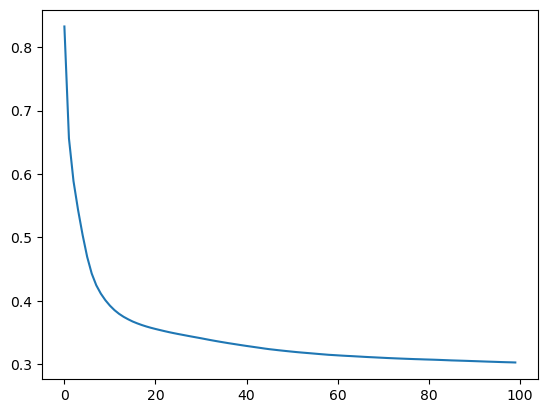

[   3.3292       31.            4.68220339    1.09957627 1047.
    2.21822034   33.94       -118.12      ] -> [2.492572] (expected [2.713])
[ 4.88390000e+00  1.60000000e+01  5.80248619e+00  1.08563536e+00
  1.66700000e+03  2.30248619e+00  3.53400000e+01 -1.19070000e+02] -> [1.4011953] (expected [1.341])
[ 4.33700000e+00  3.70000000e+01  4.03532009e+00  1.01545254e+00
  1.07500000e+03  2.37306843e+00  3.39900000e+01 -1.18460000e+02] -> [3.2477891] (expected [3.606])
[ 1.85710000e+00  4.00000000e+01  2.80804954e+00  1.08049536e+00
  1.42600000e+03  4.41486068e+00  3.40500000e+01 -1.18290000e+02] -> [1.5915868] (expected [1.438])
[ 3.19440000e+00  5.00000000e+01  4.99751244e+00  1.04228856e+00
  1.13000000e+03  2.81094527e+00  3.40500000e+01 -1.18340000e+02] -> [2.0948691] (expected [2.135])


In [6]:
# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()
 
model.eval()
with torch.no_grad():
    # Test out inference with 5 samples
    for i in range(5):
        X_sample = X_test_raw[i: i+1]
        X_sample = scaler.transform(X_sample)
        X_sample = torch.tensor(X_sample, dtype=torch.float32)
        y_pred = model(X_sample)
        print(f"{X_test_raw[i]} -> {y_pred[0].numpy()} (expected {y_test[i].numpy()})")



In [8]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder

# Read data
data = pd.read_csv("sonar.csv", header=None)
X = data.iloc[:, 0:60]
y = data.iloc[:, 60]

In [10]:
# Binary encoding of labels
encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)

# Convert to 2D PyTorch tensors
X = torch.tensor(X.values, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)

In [11]:
# Define two models
class Wide(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(60, 180)
        self.relu = nn.ReLU()
        self.output = nn.Linear(180, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.hidden(x))
        x = self.sigmoid(self.output(x))
        return x

class Deep(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(60, 60)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(60, 60)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(60, 60)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(60, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x

# Compare model sizes
model1 = Wide()
model2 = Deep()
print(sum([x.reshape(-1).shape[0] for x in model1.parameters()]))  # 11161
print(sum([x.reshape(-1).shape[0] for x in model2.parameters()]))  # 11041

11161
11041


In [12]:
# Helper function to train one model
def model_train(model, X_train, y_train, X_val, y_val):
    # loss function and optimizer
    loss_fn = nn.BCELoss()  # binary cross entropy
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    n_epochs = 300   # number of epochs to run
    batch_size = 10  # size of each batch
    batch_start = torch.arange(0, len(X_train), batch_size)

    # Hold the best model
    best_acc = - np.inf   # init to negative infinity
    best_weights = None

    for epoch in range(n_epochs):
        model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=False) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                acc = (y_pred.round() == y_batch).float().mean()
                bar.set_postfix(
                    loss=float(loss),
                    acc=float(acc)
                )
        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(X_val)
        acc = (y_pred.round() == y_val).float().mean()
        acc = float(acc)
        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())
    # restore model and return best accuracy
    model.load_state_dict(best_weights)
    return best_acc


In [13]:
# train-test split: Hold out the test set for final model evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)

# define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True)

In [14]:
cv_scores_wide = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    model = Wide()
    acc = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test])
    print("Accuracy (wide): %.2f" % acc)
    cv_scores_wide.append(acc)

Epoch 154:  17%|███████████████                                                                           | 2/12 [00:00<00:00, 892.81batch/s, acc=0.6, loss=0.607]IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 299: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 1005.55batch/s, acc=1, loss=0.21]


Accuracy (wide): 0.79


Epoch 65:   8%|███████▌                                                                                   | 1/12 [00:00<00:00, 791.68batch/s, acc=0.6, loss=0.588]IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 293: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 843.64batch/s, acc=1, loss=0.142]
IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 212:  17%|███████████████  

Accuracy (wide): 0.72


Epoch 149: 100%|██████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 1028.11batch/s, acc=0.833, loss=0.398]IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 299: 100%|███████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 912.05batch/s, acc=0.833, loss=0.318]


Accuracy (wide): 0.79


Epoch 13:   8%|███████▌                                                                                   | 1/12 [00:00<00:00, 808.15batch/s, acc=0.6, loss=0.666]IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 251:  67%|████████████████████████████████████████████████████████████                              | 8/12 [00:00<00:00, 901.96batch/s, acc=0.8, loss=0.487]IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [16]:
cv_scores_deep = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    model = Deep()
    acc = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test])
    print("Accuracy (deep): %.2f" % acc)
    cv_scores_deep.append(acc)

Epoch 154:  25%|██████████████████████▌                                                                   | 3/12 [00:00<00:00, 656.23batch/s, acc=0.9, loss=0.255]IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 299: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 759.60batch/s, acc=1, loss=0.0605]


Accuracy (deep): 0.86


Epoch 59:  42%|█████████████████████████████████████▉                                                     | 5/12 [00:00<00:00, 890.22batch/s, acc=0.5, loss=0.563]IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 299: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 802.83batch/s, acc=1, loss=0.0119]


Accuracy (deep): 0.79


Epoch 231:  58%|████████████████████████████████████████████████████▌                                     | 7/12 [00:00<00:00, 931.19batch/s, acc=0.9, loss=0.135]IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 299: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 692.77batch/s, acc=1, loss=0.0458]


Accuracy (deep): 0.79


Epoch 114:  33%|██████████████████████████████                                                            | 4/12 [00:00<00:00, 926.87batch/s, acc=0.8, loss=0.381]IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 299: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 831.38batch/s, acc=1, loss=0.0133]


Accuracy (deep): 0.93


Epoch 6:  58%|█████████████████████████████████████████████████████▋                                      | 7/12 [00:00<00:00, 862.24batch/s, acc=0.4, loss=0.697]IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 203:  25%|██████████████████████▌                                                                   | 3/12 [00:00<00:00, 758.27batch/s, acc=0.8, loss=0.367]IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 299: 100%|██████████████████

Accuracy (deep): 0.83


In [17]:
# evaluate the model
wide_acc = np.mean(cv_scores_wide)
wide_std = np.std(cv_scores_wide)
deep_acc = np.mean(cv_scores_deep)
deep_std = np.std(cv_scores_deep)
print("Wide: %.2f%% (+/- %.2f%%)" % (wide_acc*100, wide_std*100))
print("Deep: %.2f%% (+/- %.2f%%)" % (deep_acc*100, deep_std*100))

Wide: 77.24% (+/- 6.01%)
Deep: 84.14% (+/- 5.16%)


In [18]:
if wide_acc > deep_acc:
    print("Retrain a wide model")
    model = Wide()
else:
    print("Retrain a deep model")
    model = Deep()
acc = model_train(model, X_train, y_train, X_test, y_test)
print(f"Final model accuracy: {acc*100:.2f}%")

Retrain a deep model


Epoch 126:  53%|████████████████████████████████████████████████                                          | 8/15 [00:00<00:00, 845.83batch/s, acc=0.9, loss=0.245]IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 299: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 830.38batch/s, acc=1, loss=0.00904]


Final model accuracy: 85.71%


[0.031  0.0221 0.0433 0.0191 0.0964 0.1827 0.1106 0.1702 0.2804 0.4432
 0.5222 0.5611 0.5379 0.4048 0.2245 0.1784 0.2297 0.272  0.5209 0.6898
 0.8202 0.878  0.76   0.7616 0.7152 0.7288 0.8686 0.9509 0.8348 0.573
 0.4363 0.4289 0.424  0.3156 0.1287 0.1477 0.2062 0.24   0.5173 0.5168
 0.1491 0.2407 0.3415 0.4494 0.4624 0.2001 0.0775 0.1232 0.0783 0.0089
 0.0249 0.0204 0.0059 0.0053 0.0079 0.0037 0.0015 0.0056 0.0067 0.0054] -> [0.00121063] (expected [0.])
[0.0408 0.0653 0.0397 0.0604 0.0496 0.1817 0.1178 0.1024 0.0583 0.2176
 0.2459 0.3332 0.3087 0.2613 0.3232 0.3731 0.4203 0.5364 0.7062 0.8196
 0.8835 0.8299 0.7609 0.7605 0.8367 0.8905 0.7652 0.5897 0.3037 0.0823
 0.2787 0.7241 0.8032 0.805  0.7676 0.7468 0.6253 0.173  0.2916 0.5003
 0.522  0.4824 0.4004 0.3877 0.1651 0.0442 0.0663 0.0418 0.0475 0.0235
 0.0066 0.0062 0.0129 0.0184 0.0069 0.0198 0.0199 0.0102 0.007  0.0055] -> [0.5916423] (expected [1.])
[0.0968 0.0821 0.0629 0.0608 0.0617 0.1207 0.0944 0.4223 0.5744 0.5025
 0.3488 0.17 

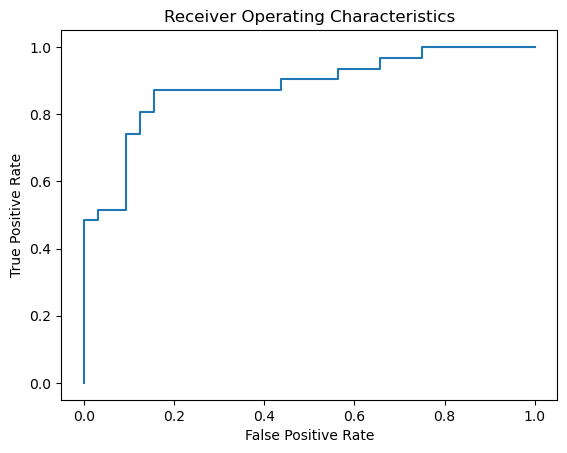

In [19]:
model.eval()
with torch.no_grad():
    # Test out inference with 5 samples
    for i in range(5):
        y_pred = model(X_test[i:i+1])
        print(f"{X_test[i].numpy()} -> {y_pred[0].numpy()} (expected {y_test[i].numpy()})")

    # Plot the ROC curve
    y_pred = model(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr) # ROC curve = TPR vs FPR
    plt.title("Receiver Operating Characteristics")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()